In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
import os
import pandas as pd
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt

In [8]:
# Load training data
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

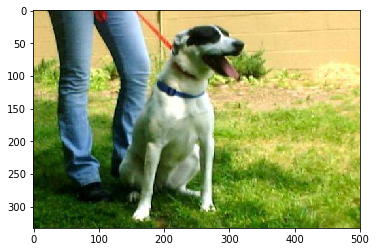

In [9]:
# Show sample image
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

In [10]:
# Split into train and validation set
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [12]:
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [14]:
validate_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [15]:
    def build_model():
        alexnet = Sequential()

        # Layer 1 Conv
        alexnet.add(Conv2D(input_shape=(224, 224, 3), filters=96,
                           kernel_size=(11, 11), strides=(4, 4), padding='same'))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))
        alexnet.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 2 Conv
        alexnet.add(ZeroPadding2D((2, 2)))
        alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))
        alexnet.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 3 Conv
        alexnet.add(ZeroPadding2D((1, 1)))
        alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same'))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))

        # Layer 4 Conv
        alexnet.add(ZeroPadding2D((1, 1)))
        alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same'))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))

        # Layer 5 Conv
        alexnet.add(ZeroPadding2D((1, 1)))
        alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))
        alexnet.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 6 FC
        alexnet.add(Dense(4096))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))
        alexnet.add(Dropout(0.5))

        # Layer 7 FC
        alexnet.add(Dense(4096))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('relu'))
        alexnet.add(Dropout(0.5))

        # Layer 8 Softmax
        alexnet.add(Dense(10))
        alexnet.add(BatchNormalization())
        alexnet.add(Activation('softmax'))

        return alexnet

In [16]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 256)       1024      
__________

In [18]:
from keras.optimizers import SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse')

In [20]:
history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validate_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/3


ValueError: Error when checking target: expected activation_8 to have 4 dimensions, but got array with shape (15, 1)

In [ ]:
# save model
model.save_weights("model.h5")